# NER
В этом документе я создаю теги для нужных нам сущностей, обучаю модель распознавания на них и вывожу результат этого распознавания


В этой ячейке проверяем, как работает модель spaCy для русского языка. Поскольку сейчас исопльзуется предобученная на датасете новостей модель, она умеет определять только формальные сущности (персона, локация, время), которые неприменимы к нашему проекту. Поэтому далее я буду создавать распознаватель конкретно под наши задачи. 

А в этой ячейке удостоверяемся, что spaCy корректно отвечает на заданные для нее условия (определила "Ульяна" как "персону", "Москве" как "локацию"

In [3]:
import spacy
import pandas as pd
import random
import json
from spacy.lang.ru import Russian
from spacy.pipeline import EntityRuler

import ru_core_news_lg

Считываем датасет всех команд, далее выбираем отдельно столбец с командами для дальнейшей работы

In [4]:
import pandas as pd
all_df = pd.read_csv('all_commands.csv')
all_commands = pd.read_csv('all_commands.csv')[['command']]

In [5]:
all_df[:3]

,Unnamed: 0.1,Unnamed: 0,command,orig,intent,entity
0,0,0,я пиратом быть хочу,хожу пиратом номер два,choose_your_fighter,fighter
1,1,1,хочу чтобы пираткой была третья,третьим ходить хочу пиратом,choose_your_fighter,fighter
2,2,2,пират сделал третий с пиратом ход,сделал пират третий ход,choose_your_fighter,fighter


In [6]:
# Выбор нескольких колонок
selected_columns = ['orig', 'intent', 'entity']
new_df = all_df[selected_columns].copy()

new_df.rename(columns = {'orig':'command'}, inplace = True)
# # Сохранение нового датасета в файл
# new_df.to_csv('new_dataset.csv', index=False)


In [7]:
columns_to_del = ['orig', 'Unnamed: 0', 'Unnamed: 0.1']
all_drop_df = all_df.drop(columns_to_del, axis=1)


In [8]:
all_drop_df[:2]

,command,intent,entity
0,я пиратом быть хочу,choose_your_fighter,fighter
1,хочу чтобы пираткой была третья,choose_your_fighter,fighter


In [9]:
# Stack (concatenate) the DataFrames vertically
all_new_df = pd.concat([all_drop_df, new_df], axis=0)

# Reset the index of the stacked DataFrame
all_new_df = all_new_df.reset_index(drop=True)

# Print the stacked DataFrame
all_new_df

,command,intent,entity
0,я пиратом быть хочу,choose_your_fighter,fighter
1,хочу чтобы пираткой была третья,choose_your_fighter,fighter
2,пират сделал третий с пиратом ход,choose_your_fighter,fighter
3,я пиратом первым был,choose_your_fighter,fighter
4,может я хотела быть третьей пираткой,choose_your_fighter,fighter
...,...,...,...
51769,иду по второму,move_on_horse,horse_direction
51770,хочу как шестой,move_on_horse,horse_direction
51771,пойду по второму направлению,move_on_horse,horse_direction
51772,пойду по второму направлению,move_on_horse,horse_direction


In [10]:
# all_new_df['intent'].nunique()

Переводим колонку команд в список

In [11]:
all_commands_list = []
for i in all_commands['command']:
    all_commands_list.append(i)
# for i in all_commands_list['orig']:
#     all_commands_list.append(i)

In [12]:
all_commands_list2 = []
for i in all_new_df['command']:
    all_commands_list2.append(i)

Функция для записи списка команд в JSON файл, с ним далее удобнее работать

In [13]:
def write_list(a_list):
    with open("all_commands.json", "w", encoding='utf8') as f:
        json.dump(a_list, f, ensure_ascii=False)

write_list(all_commands_list)

Заводим 2 функции для чтения файла и сохранения в файл. Загружаем из JSON, сохраняем тоже в JSON

In [14]:
def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return (data)

def save_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

Пишем функции для обработки команд. 

In [15]:
# В отдельном файле у нас есть список сущностей и их лэйбл. Библиотека spaCy требует особой 
# структуры данных для обработки пар сущность — лэйбл (это паттерн). Эта функция позволяет создать такую структуру
# из имеющихся данных 

def create_training_data(file, type):
    data = load_data(file)
    patterns = []
    for item in data:
        pattern = {
                    "label": type,
                    "pattern": item
                    }
        patterns.append(pattern)
    return (patterns)



# Эта фунция создает и сохраняет кастомную модель NER, которая работает с созданными выше паттернами.

def generate_rules(patterns):
    nlp = Russian()
    ruler = nlp.add_pipe("entity_ruler")
    ruler.add_patterns(patterns)
    nlp.to_disk("jackal_ner_all_entities")
    

    
# Эта функция обрабатывает входящий текст (ищет сущности) с использованием созданной выше модели и записывает
# найденное в список 
    
def test_model(model, text):
    doc = nlp(text)
    results = []
    entities = []
    for ent in doc.ents:
        entities.append((ent.start_char, ent.end_char, ent.label_))
    if len(entities) > 0:
        results = [text, {"entities": entities}] # специальный формат для spaCy
        return (results)
                

                                                                            

Создаем паттерны для каждого типа сущностей и объединяем в единый список — это нужно, чтобы конечная модель имела в себе паттерны сущностей всех типов

In [16]:
patterns_dir = create_training_data("NER_dir.json", "DIR")
patterns_tile = create_training_data("NER_tiles.json", "TILE")
pattern_act = create_training_data("NER_act.json", "ACT")
pattern_num = create_training_data("NER_num.json", "NUM")

all_patterns = patterns_dir + patterns_tile + pattern_act + pattern_num

Создаем модель распознавания сущностей

In [17]:
generate_rules(all_patterns)

# Объединила паттерны и сделала единую модель, чтобы иметь множество лейблов, а не один
# print (patterns)

Функция ниже создает список команд из JSON файла, а далее создает тренировочный размеченный датасет в 70% от всего объема команд

In [18]:
def get_text(file):
    data = load_data(file)
    text = []
    for item in data:
        text.append(item) 
    return (text)


##### ЭКСПЕРИМЕНТ №1 Создание тренировочного датасета

In [ ]:
nlp = spacy.load("jackal_ner_all_entities")
ALL_DATA = []
outsiders = []
text = get_text("all_commands.json")
hits = []
counter = 0
test_size = round(0.7 * len(text))
while counter < len(text): # делаем тренировочный датасет в 70% от всего
    for command in text:
        command = command.strip()
    #        command = command.replace("\n", " ")
        results = test_model(nlp, command)
        if results != None:
            ALL_DATA.append(results)
            
        ########################
        #далее идут временный команды. нужны для отслеживания качества
        else:
             outsiders.append(command)
            
        
        #######################
        counter += 1

In [11]:
TRAIN_DATA = ALL_DATA[:test_size]

In [12]:
test_data = ALL_DATA[test_size:]

In [13]:
save_data("ML_NER_train_data.json", TRAIN_DATA)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

ALL_DATA = pd.DataFrame(ALL_DATA) # стандартный брейк на трейн и тест не производился, поскольку далее нужны json 

In [15]:
X = ALL_DATA[[0]]
y = ALL_DATA[[1]]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .7)

##### ЭКСПЕРИМЕНТ №2 Создание тренировочного датасета #2

In [42]:
nlp = spacy.load("jackal_ner_all_entities")
ALL_DATA = []
outsiders = []
text = get_text("all_commands.json")
hits = []
counter = 0
test_size = round(0.7 * len(text))
while counter < len(text): # делаем тренировочный датасет в 70% от всего
    for command in text:
        command = command.strip()
    #        command = command.replace("\n", " ")
        results = test_model(nlp, command)
        if results != None:
            ALL_DATA.append(results)
            
        ########################
        #далее идут временный команды. нужны для отслеживания качества
        else:
             outsiders.append(command)
            
        
        #######################
        counter += 1

In [43]:
TRAIN_DATA2 = ALL_DATA[:test_size] # full data
test_data2 = ALL_DATA[test_size:]

save_data("ML_NER_train_data2.json", TRAIN_DATA2)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

ALL_DATA = pd.DataFrame(ALL_DATA) # стандартный брейк на трейн и тест не производился, поскольку далее нужны json 
X = ALL_DATA[[0]]
y = ALL_DATA[[1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .7)

## Тренировка модели

In [19]:
import random
from spacy.training.example import Example

def train_spacy(data, epochs):
    TRAIN_DATA = data
    nlp = spacy.blank("ru")
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner")
    else:
        ner = nlp.get_pipe("ner")
    
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.select_pipes(disable=other_pipes):
        optimizer = nlp.initialize()
        for epoch in range(epochs):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                example = Example.from_dict(nlp.make_doc(text), annotations)
                nlp.update(
                    [example],
                    sgd=optimizer,
                    losses=losses
                )
            print(f"Epoch {epoch}, losses {losses}")
    return nlp

In [20]:
import re
import spacy
import nltk
nltk.download("stopwords")
#--------#

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pabakst/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

##### Эксперимент №1

In [18]:
TRAIN_DATA = load_data("ML_NER_train_data.json")
random.shuffle(TRAIN_DATA)


In [19]:
nlp = train_spacy(TRAIN_DATA, 30)
nlp.to_disk("jackal_ner_trained_model")

Epoch 0, losses {'ner': 1209.362697350957}
Epoch 1, losses {'ner': 418.0132782415199}
Epoch 2, losses {'ner': 298.9733012921843}
Epoch 3, losses {'ner': 196.6050681297542}
Epoch 4, losses {'ner': 164.72349224351584}
Epoch 5, losses {'ner': 127.8535100090867}
Epoch 6, losses {'ner': 113.04108465714282}
Epoch 7, losses {'ner': 110.2170672081113}
Epoch 8, losses {'ner': 92.4750738352342}
Epoch 9, losses {'ner': 116.0856071785099}
Epoch 10, losses {'ner': 99.27456492477025}
Epoch 11, losses {'ner': 119.54105702693973}
Epoch 12, losses {'ner': 96.77559156767457}
Epoch 13, losses {'ner': 79.74920168418925}
Epoch 14, losses {'ner': 88.43770120556705}
Epoch 15, losses {'ner': 101.93594694040155}
Epoch 16, losses {'ner': 110.55724684573198}
Epoch 17, losses {'ner': 78.3234213482761}
Epoch 18, losses {'ner': 113.32516434290599}
Epoch 19, losses {'ner': 92.24953517867372}
Epoch 20, losses {'ner': 69.99834994970784}
Epoch 21, losses {'ner': 88.17668782694231}
Epoch 22, losses {'ner': 82.4328526122

In [39]:
def input_for_gui (test):
    arrow = ['стрелка', 'указатель']
    balloon = ['воздушный шар', 'шар']
    barrel = ['бочка']
    cannibal = ['людоед']
    castle = ['крепость']
    castle_girl = ["девушка", "абориген", "аборигенка"]
    croc = ['крокодил']
    gold = ['сундук', 'деньги', 'сокровища',"золотишко", "монета", "золото", "деньга", "монетка", 
            "клад", "сундучок", "мелочь", "сокровище", "сокровищница"]
    horse = ['конь', 'лошадь']
    ice = ['лед', 'лёд']
    labyrinth = [ 'лабиринт', 'джунгли', 'пустыня', 'болото',
        'горы', "тропик", "пустынь", "заросль", "гора", "скала" , "лес", 
         "песок", "дюна","тропический", "леса"]
    plane = ['самолет', "самолёт"]
    trap = ['капкан', 'ловушка']
    cannon = ['пушка']
    field = ['поляна', 'пустышка', "клетка",
         "клеточка","холм"]
    
    
#     test = 'первым пиратом пойду налево и попаду на шар'
    test = preprocess_text(test)
    nlp = spacy.load("jackal_ner_trained_model") # сущности определяются посредством обучения модели
    doc = nlp(test)
    results = test_model(nlp, command)
    dict_ = {}
    for ent in doc.ents:
        dict_[ent.label_] = ent.text
#         print (ent.text, ent.label_)
    print(dict_)
    
    if "NUM" in dict_.keys():
        if "пер" in dict_["NUM"]:
            number = 1
        elif "втор" in dict_["NUM"]:
            number = 2     
        elif "тр" in dict_["NUM"]:
            number = 3
    else:
        number = 101
        
    if "DIR" in dict_.keys():
        if "лев" in dict_["DIR"]:
            direction = 0
        elif "прав" in dict_["DIR"]:
            direction = 1   
        elif "прям" in dict_["DIR"]:
            direction = 2  
        elif "наз" in dict_["DIR"]:
            direction = 3
    
        return number, direction 
#         break

            
    elif "DIR" not in dict_.keys()and "TILE" in dict_.keys() :
        if dict_["TILE"] in arrow:
            tile = 1
        elif dict_["TILE"] in balloon:
            tile = 8   
        elif dict_["TILE"] in barrel:
            tile = 9     
        elif dict_["TILE"] in cannibal:
            tile = 10   
        elif dict_["TILE"] in castle:
            tile = 11             
        elif dict_["TILE"] in castle_girl:
            tile = 12  
        elif dict_["TILE"] in croc:
            tile = 13 
        elif dict_["TILE"] in gold:
            tile = 14
        elif dict_["TILE"] in horse:
            tile = 19            
        elif dict_["TILE"] in ice:
            tile = 20            
        elif dict_["TILE"] in labyrinth:
            tile = 21   
        elif dict_["TILE"] in field:
            tile = 25               
        elif dict_["TILE"] in plane:
            tile = 29               
        elif dict_["TILE"] in trap:
            tile = 30   
        elif dict_["TILE"] in cannon:
            tile = 31             
    
        return number, tile  
#         break
            
# print(results[1])

##### Эксперимент №2

In [46]:
TRAIN_DATA2 = load_data("ML_NER_train_data2.json")
random.shuffle(TRAIN_DATA2)

In [47]:
nlp = train_spacy(TRAIN_DATA2, 30)
nlp.to_disk("jackal_ner_trained_model_2")

Epoch 0, losses {'ner': 1192.3796189962734}
Epoch 1, losses {'ner': 438.75923287614535}
Epoch 2, losses {'ner': 227.20199471466904}
Epoch 3, losses {'ner': 173.81227575955631}
Epoch 4, losses {'ner': 179.93529382738785}
Epoch 5, losses {'ner': 161.01152465172535}
Epoch 6, losses {'ner': 168.58750400037758}
Epoch 7, losses {'ner': 85.14953879835709}
Epoch 8, losses {'ner': 90.39763094912121}
Epoch 9, losses {'ner': 135.5226072889653}
Epoch 10, losses {'ner': 112.43301182417362}
Epoch 11, losses {'ner': 91.356357433581}
Epoch 12, losses {'ner': 91.9319134465317}
Epoch 13, losses {'ner': 58.257581652239196}
Epoch 14, losses {'ner': 86.48136508820376}
Epoch 15, losses {'ner': 92.7242524631138}
Epoch 16, losses {'ner': 81.2744690465102}
Epoch 17, losses {'ner': 89.93876815396483}
Epoch 18, losses {'ner': 79.45619466024219}
Epoch 19, losses {'ner': 81.77474603188068}
Epoch 20, losses {'ner': 102.97479292045449}
Epoch 21, losses {'ner': 88.41012265701478}
Epoch 22, losses {'ner': 100.77128501

In [58]:
def input_for_gui2 (test):
    arrow = ['стрелка', 'указатель']
    balloon = ['воздушный шар', 'шар']
    barrel = ['бочка']
    cannibal = ['людоед']
    castle = ['крепость']
    castle_girl = ["девушка", "абориген", "аборигенка"]
    croc = ['крокодил']
    gold = ['сундук', 'деньги', 'сокровища',"золотишко", "монета", "золото", "деньга", "монетка", 
            "клад", "сундучок", "мелочь", "сокровище", "сокровищница"]
    horse = ['конь', 'лошадь']
    ice = ['лед', 'лёд']
    labyrinth = [ 'лабиринт', 'джунгли', 'пустыня', 'болото',
        'горы', "тропик", "пустынь", "заросль", "гора", "скала" , "лес", 
         "песок", "дюна","тропический", "леса"]
    plane = ['самолет', "самолёт"]
    trap = ['капкан', 'ловушка']
    cannon = ['пушка']
    field = ['поляна', 'пустышка', "клетка",
         "клеточка","холм"]
    
    
#     test = 'первым пиратом пойду налево и попаду на шар'
    test = preprocess_text(test)
    nlp = spacy.load("jackal_ner_trained_model_2") # сущности определяются посредством обучения модели
    doc = nlp(test)
    results = test_model(nlp, command)
    dict_ = {}
    for ent in doc.ents:
        dict_[ent.label_] = ent.text
#         print (ent.text, ent.label_)
    print(dict_)
    
    if "NUM" in dict_.keys():
        if "пер" in dict_["NUM"]:
            number = 1
        elif "втор" in dict_["NUM"]:
            number = 2     
        elif "тр" in dict_["NUM"]:
            number = 3
    else:
        number = 101
        
    if "DIR" in dict_.keys():
        if "лев" in dict_["DIR"]:
            direction = 0
        elif "прав" in dict_["DIR"]:
            direction = 1   
        elif "прям" in dict_["DIR"]:
            direction = 2  
        elif "наз" in dict_["DIR"]:
            direction = 3
    
        return number, direction 
#         break

            
    elif "DIR" not in dict_.keys()and "TILE" in dict_.keys() :
        if dict_["TILE"] in arrow:
            tile = 1
        elif dict_["TILE"] in balloon:
            tile = 8   
        elif dict_["TILE"] in barrel:
            tile = 9     
        elif dict_["TILE"] in cannibal:
            tile = 10   
        elif dict_["TILE"] in castle:
            tile = 11             
        elif dict_["TILE"] in castle_girl:
            tile = 12  
        elif dict_["TILE"] in croc:
            tile = 13 
        elif dict_["TILE"] in gold:
            tile = 14
        elif dict_["TILE"] in horse:
            tile = 19            
        elif dict_["TILE"] in ice:
            tile = 20            
        elif dict_["TILE"] in labyrinth:
            tile = 21   
        elif dict_["TILE"] in field:
            tile = 25               
        elif dict_["TILE"] in plane:
            tile = 29               
        elif dict_["TILE"] in trap:
            tile = 30   
        elif dict_["TILE"] in cannon:
            tile = 31             
    
        return number, tile  
#         break
            
# print(results[1])

In [59]:
input_for_gui2("первым пиратом пойду попаду на шар")

{'NUM': 'первый', 'ACT': 'пират', 'TILE': 'шар'}


(1, 8)

# Создание строк из словаря и классификация модели

### Cоздаем эмбеддинги на rubert-tiny, тк у него был лучший перформанс в исследованиях до

In [26]:
# загрузка библиотеки hugging face
!pip install transformers

In [27]:
from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

model = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny")

###### Эксперимент №1

In [60]:
# test = 'первым пиратом пойду налево и попаду на шар'


# test = preprocess_text(test)
# nlp = spacy.load("jackal_ner_all_entities") # все сущности посчитаны искусственно, механически
# doc = nlp(test)
# results = test_model(nlp, command)
# for ent in doc.ents:
#     print (ent.text, ent.label_)
# # print(results[1])

nlp = spacy.load("jackal_ner_trained_model") # сущности определяются посредством обучения модели
list_of_cores = []
for i in all_commands_list:
    test = preprocess_text(i)
    doc = nlp(test)
    dict_ = {}
    for ent in doc.ents:
        dict_[ent.label_] = ent.text
    #       print (ent.text, ent.label_)

    new_string = (' ').join(dict_.values())
    if new_string.isspace():
        new_string= "NaN"
    list_of_cores.append(new_string)
    
all_commands['core_ent'] = list_of_cores

In [61]:
all_commands[]

,command,core_ent
0,я пиратом быть хочу,пират
1,хочу чтобы пираткой была третья,пиратка третий
2,пират сделал третий с пиратом ход,пират третий
3,я пиратом первым был,пират первый
4,может я хотела быть третьей пираткой,третий пиратка
...,...,...
25882,место иду на второе я,второй
25883,я хочу был он чтобы шестым,шестой
25884,я сторону в другую,
25885,я в другую сторону,


In [69]:
sentences = all_commands.core_ent

# Преобразование каждого предложения в эмбеддинг
embeddings_rubert_tiny_ner = []
for sentence in sentences:
   inputs = tokenizer(sentence, return_tensors="pt")
   outputs = model(**inputs)
   last_hidden_state = outputs[0]  # замена строки
   sentence_embedding = last_hidden_state.mean(dim=1).squeeze().tolist()
   embeddings_rubert_tiny_ner.append(sentence_embedding)

# получили список списков

In [70]:
embeddings_rubert_tiny_ner = np.array(embeddings_rubert_tiny_ner)

In [71]:
np.save('embeddings_rubert_tiny_ner.npy', embeddings_rubert_tiny_ner)

In [72]:
all_df['intent'].nunique()

14

In [73]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
all_df['intent'] = le.fit_transform(all_df.intent)
np.save('labels_ent.npy', all_df.intent)

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.load('embeddings_rubert_tiny_ner.npy') # матрица признаков
y = np.load('labels_ent.npy') # вектор целевых переменных

# Сначала разбиваем на train и test, с перемешиванием
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Далее разбиваем train на train и validation, с перемешиванием
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

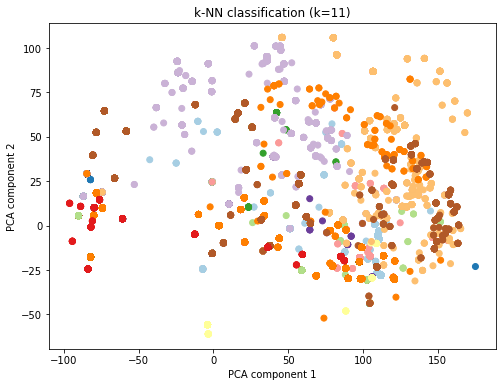

Accuracy: 0.500


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


# Поиск оптимального значения параметра k с помощью кросс-валидации
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_k = grid_search.best_params_['n_neighbors']

# Обучение модели k-NN с оптимальным значением параметра k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Предсказание меток классов на тестовой выборке
y_pred = knn.predict(X_test)

# Сокращение размерности признаков с помощью метода главных компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Отображение результатов классификации на графике
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('k-NN classification (k=%i)' % best_k)
plt.show()

# Подсчет точности классификации на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %0.3f" % accuracy)

##### Эксперимент №2

In [23]:
# test = 'первым пиратом пойду налево и попаду на шар'


# test = preprocess_text(test)
# nlp = spacy.load("jackal_ner_all_entities") # все сущности посчитаны искусственно, механически
# doc = nlp(test)
# results = test_model(nlp, command)
# for ent in doc.ents:
#     print (ent.text, ent.label_)
# # print(results[1])

nlp = spacy.load("jackal_ner_trained_model_2") # сущности определяются посредством обучения модели
list_of_cores = []
for i in all_commands_list2:
    test = preprocess_text(i)
    doc = nlp(test)
    dict_ = {}
    for ent in doc.ents:
        dict_[ent.label_] = ent.text
    #       print (ent.text, ent.label_)

    new_string = (' ').join(dict_.values())
    if new_string.isspace():
        new_string= "NaN"
    list_of_cores.append(new_string)
    
all_new_df['core_ent'] = list_of_cores

In [24]:
all_new_df[:3]

,command,intent,entity,core_ent
0,я пиратом быть хочу,choose_your_fighter,fighter,пират
1,хочу чтобы пираткой была третья,choose_your_fighter,fighter,пиратка третий
2,пират сделал третий с пиратом ход,choose_your_fighter,fighter,пират третий


In [ ]:
sentences = all_new_df.core_ent

# Преобразование каждого предложения в эмбеддинг
embeddings_rubert_tiny_ner = []
for sentence in sentences:
   inputs = tokenizer(sentence, return_tensors="pt")
   outputs = model(**inputs)
   last_hidden_state = outputs[0]  # замена строки
   sentence_embedding = last_hidden_state.mean(dim=1).squeeze().tolist()
   embeddings_rubert_tiny_ner.append(sentence_embedding)

# получили список списков

In [ ]:
embeddings_rubert_tiny_ner2 = np.array(embeddings_rubert_tiny_ner2)

In [ ]:
np.save('embeddings_rubert_tiny_ner2.npy', embeddings_rubert_tiny_ner2)

In [ ]:
all__new_df['intent'].nunique()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
all_new_df['intent'] = le.fit_transform(all_new_df.intent)
np.save('labels_ent2.npy', all_new_df.intent)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X2 = np.load('embeddings_rubert_tiny_ner2.npy') # матрица признаков
y2 = np.load('labels_ent2.npy') # вектор целевых переменных

# Сначала разбиваем на train и test, с перемешиванием
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=True, random_state=42)

# Далее разбиваем train на train и validation, с перемешиванием
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score


# Поиск оптимального значения параметра k с помощью кросс-валидации
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train2, y_train2)
best_k = grid_search.best_params_['n_neighbors']

# Обучение модели k-NN с оптимальным значением параметра k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train2, y_train2)

# Предсказание меток классов на тестовой выборке
y_pred2 = knn.predict(X_test2)

# Сокращение размерности признаков с помощью метода главных компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X2)

# Отображение результатов классификации на графике
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('k-NN classification (k=%i)' % best_k)
plt.show()

# Подсчет точности классификации на тестовой выборке
accuracy = accuracy_score(y_test2, y_pred2)
print("Accuracy: %0.3f" % accuracy)

## Считаем f-меру

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score


# Print the results
print("Precision:", precision)
print("Recall:", recall)

# Вычисление F-меры
f_score = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)


# Вычисление F-меры
f_score2 = f1_score(y_true2, y_pred2)
precision2 = precision_score(y_true2, y_pred2)
recall2 = recall_score(y_true2, y_pred2)



# Вывод результата
print(f"F1-score для эксперимента №1: {f_score}, precision: {precision}, recall: {recall}")
print(f"F1-score для эксперимента №2 [модель с перефразом]: {f_score2}, precision: {precision2}, recall: {recall2}")

In [ ]:
X_test_list = X_test[0].tolist()

In [ ]:
nlp = spacy.load("jackal_ner_trained_model")
y_pred = []
for i in X_test_list:
#     test = preprocess_text(i) -- меняет индекс вхождения слова, осторожно при сравнении по индексу вхождения
    results = test_model(nlp, i)
    if results is None:
        y_pred.append("NaN")
#         print('NaN')
    else:
        y_pred.append(results[1])
#         print(results[1])

In [ ]:
y_true = y_test[1].tolist() 

In [ ]:
# надо сравнить значения на y_pred и y_true, отношение y_pred к y_test

# print(f'type(y_true) = {type(y_true)}, type(y_pred) = {type(y_pred)}')
# len(y_pred) == len(y_true)

### Метрики

In [ ]:
print(y_pred[12], y_true[12])

In [ ]:
TP, TN, FP, FN = 0, 0, 0, 0

for i in range(0,len(y_true)):
    if y_true[i] == y_pred[i]:
        TP += 1
    elif y_true[i] != "NaN" and y_pred[i] == "NaN":
        FN += 1
    elif y_true[i] == "NaN" and y_pred[i] != "NaN":
        FP += 1     
    elif y_true[i] == "NaN" and y_pred[i] == "NaN":
        TN += 1 
        
print(f'Отношение верных ответов ко всему кол-ву строк (сравнение по индексам): {TP/len(y_true)}')

In [ ]:
len(y_true)

In [ ]:
print(f'значения для NER модели равна: {TP, TN, FP, FN}')

In [ ]:
# Ручная f-мера

def f1_score (TP, TN, FP, FN):
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = (2 * precision * recall) / (precision + recall)
    
    return f1_score

In [ ]:
print(f1_score(TP, TN, FP, FN))

In [ ]:
print(f'F1-мера NER модели равна: {f1_score(TP, TN, FP, FN)}') # но на самом деле так потому что нет TN и FP